# Evaluation using DIGEST

## Setup

In [19]:
import os
import sys
import json
import math
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# ==== import single validation script ====
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from single_validation import single_validation

## Cluster itself

Compare a target cluster of diseases based on dunn index and sillhouette score, while the random runs are simply cluster size preserving perturbation of cluster assignments.

## Gene Cluster

### Cluster input parameters

In [13]:
tar_set = "input/gene_cluster.txt"
tar_id_type = "symbol"
mode = "cluster"
out_dir = "results/"
runs = 1000
perc = 100
background_model="complete"

### Run script

In [14]:
single_validation(tar=tar_set, tar_id=tar_id_type, mode=mode, out_dir=out_dir, runs=runs, replace=perc, verbose=True)
with open(out_dir+'digest_'+mode+'_result.json', 'r') as f:
    results = json.load(f)

[00:00:00|843.59MB] Starting validation ...
[00:00:00|843.59MB] Load mappings for input into cache ...
[00:00:01|830.97MB] Load distances for input into cache ...
[00:00:10|2630.47MB] Load input data ...
[00:00:10|2630.47MB] Validation of input ...
Missing values for pathway.kegg :9/20
[00:00:11|2630.98MB] Validation of random runs ...
[00:04:54|2632.26MB] Save files
[00:04:54|2632.26MB] Finished validation


### Inspect results

In [4]:
pd.DataFrame(results["p_values"])

,di,ss,dbi
go.BP,0.119880,0.10989,0.016983
go.CC,0.247752,1.00000,0.780220
go.MF,0.321678,1.00000,0.244755
pathway.kegg,0.031968,1.00000,0.964036


In [51]:
pd.DataFrame(results["input_values"])

,di,ss,ss_inter,dbi,missing_ids
go.BP,0.112353,-0.650000,"{'0': -0.5555555555555556, '1': -0.72727272727...",0.125108,"[SHC4, PGR, EGFR, TFF1, AGR2, ZIC1, S100A9, AR..."
go.CC,0.162656,-1.000000,"{'1': -1.0, '0': -1.0}",1.777019,"[SHC4, PGR, EGFR, TFF1, AGR2, ZIC1, S100A9, AR..."
go.MF,0.171909,-0.900000,"{'0': -0.7777777777777778, '1': -1.0}",1.484198,"[SHC4, PGR, EGFR, TFF1, AGR2, ZIC1, S100A9, AR..."
pathway.kegg,0.101576,-0.909091,"{'0': -0.75, '1': -1.0}",0.773883,"[COL9A3, KRT16, SHC4, ESR1, PGR, EGFR, TFF1, S..."


In [42]:
# prepare for scatterplot
df = pd.DataFrame.from_dict(results["p_values"])
df = df.rename_axis('attribute').reset_index()
df["log_di"] = df["di"].apply(lambda x: -math.log10(x))
df = df.replace({"go.BP": "GO.BP", "go.CC": "GO.CC", "go.MF": "GO.MF", "pathway.kegg": "KEGG"})
# prepare for mappibility plot
in_put = pd.read_csv(tar_set, sep="\t", names=["id","cluster"])
mapped_df = in_put.copy()
for att in results["input_values"]["mapped_ids"]:
    mapped_df[att] = [1 if x in results["input_values"]["mapped_ids"][att] else 0 for x in in_put["id"]]
mapped_df = mapped_df.groupby("cluster", as_index = False).agg(sum).melt('cluster', var_name='att', value_name='count')
mapped_df = mapped_df.replace({"go.BP": "GO.BP", "go.CC": "GO.CC", "go.MF": "GO.MF", "pathway.kegg": "KEGG"})
cluster_sizes = in_put["cluster"].value_counts().to_dict()
mapped_df["fraction"] = mapped_df.apply(lambda x: x['count']/cluster_sizes[x['cluster']], axis=1)

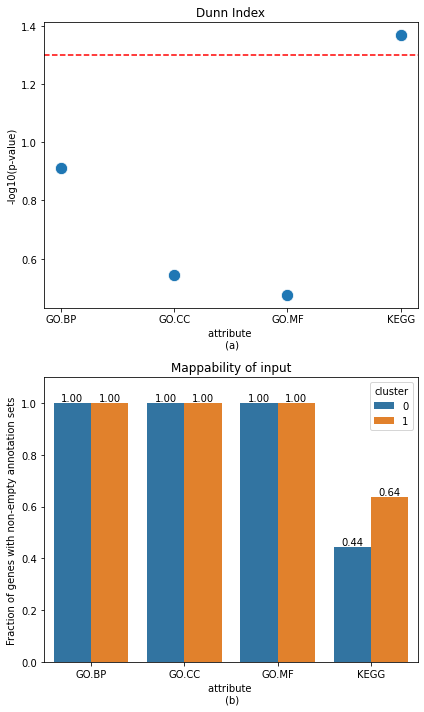

In [79]:
fig, axes = plt.subplots(2, 1, figsize=(6,10))
sns.scatterplot(x=df['attribute'], y=df['log_di'], s=150, ax=axes[0])
axes[0].set(title="Dunn Index", ylabel="-log10(p-value)", xlabel="attribute \n (a)")
axes[0].axhline(y=-math.log10(0.05), color="red",linestyle='--')
sns.barplot(x ="att", y = 'fraction', data = mapped_df, hue = "cluster", ax=axes[1])
axes[1].set(title="Mappability of input", xlabel="attribute \n (b)", ylabel="Fraction of genes with non-empty annotation sets", ylim=(0, 1.1))
for container in axes[1].containers:
    axes[1].bar_label(container,  fmt='%.2f')
fig.tight_layout() 
fig.savefig("mode_gene-cluster_overview.png", bbox_inches='tight')

In [ ]:
inp = pd.read_csv("input/gene_cluster.txt", sep="\t", names=["id","cluster"])
to_ids = pd.read_csv("../mapping_files/gene_id_mapping.csv")
to_atts = pd.read_csv("../mapping_files/gene_att_mapping.csv")
hit = to_atts[to_atts["entrezgene"].isin(to_ids[to_ids["symbol"].isin(inp["id"])]["entrezgene"])].reset_index(drop=True)
hit = hit.merge(to_ids[to_ids["symbol"].isin(inp["id"])][["entrezgene","symbol"]]).merge(inp, left_on='symbol', right_on='id')

In [ ]:
tmp = hit[["symbol","cluster", "pathway.kegg"]].fillna("")
tmp.sort_values(["cluster","pathway.kegg"], ascending=[True, False])

## Disease Cluster 1

In [ ]:
tar_set = "input/icd10_cluster.txt"
tar_id_type = "ICD-10"
mode = "cluster"
out_dir = "results/"
runs = 1000
perc = 100

### Run script

In [ ]:
single_validation(tar=tar_set, tar_id=tar_id_type, mode=mode, out_dir=out_dir, runs=runs, replace=perc, verbose=True)
with open(out_dir+'digest_'+mode+'_result.json', 'r') as f:
    results2 = json.load(f)

## Set itself

Compare a target set in itself.

## Disease Set

### Set input parameters

In [80]:
tar_set = "input/target_disease_set.txt"
tar_id_type = "ICD-10"
mode = "set"
out_dir = "results/"
runs = 1000
background_model="complete"

### Run script

In [82]:
single_validation(tar=tar_set, tar_id=tar_id_type, mode=mode, out_dir=out_dir, runs=runs, background_model=background_model, verbose=True)
with open(out_dir+'digest_'+mode+'_result.json', 'r') as f:
    data = json.load(f)

[00:00:00|2706.55MB] Starting validation ...
[00:00:00|2706.55MB] Load mappings for input into cache ...
[00:00:02|2906.87MB] Load distances for input into cache ...
[00:00:03|2986.51MB] Validation of input ...
Missing values for disgenet.genes_related_to_disease :1/25
Missing values for disgenet.variants_related_to_disease :1/25
Missing values for ctd.pathway_related_to_disease :2/25
[00:00:03|2986.77MB] Validation of random runs ...
[00:00:30|2990.23MB] Calculating p-values ...
[00:00:30|2990.23MB] Save files
[00:00:30|2990.23MB] Finished validation


### Inspect results

In [157]:
# prepare scatter
data_df = data.copy()
data_df = pd.DataFrame.from_dict({'p_values':data_df["p_values"]})
data_df = data_df.rename_axis('attribute').reset_index()
data_df["log_p-values"] = data_df["p_values"].apply(lambda x: -math.log10(x))
data_df = data_df.replace({"disgenet.genes_related_to_disease":"related genes", "disgenet.variants_related_to_disease":"related variants", "ctd.pathway_related_to_disease":"KEGG"})
data_df = data_df.sort_values(['attribute']).reset_index(drop=True)
# prepare for mappibility plot
in_put = pd.read_csv(tar_set, sep="\t", names=["id", "desc"])
mapped_df = in_put.copy()
for att in data["input_values"]["mapped_ids"]:
    mapped_df[att] = [1 if x in data["input_values"]["mapped_ids"][att] else 0 for x in in_put["id"]]
mapped_df= mapped_df[["disgenet.genes_related_to_disease", "disgenet.variants_related_to_disease", "ctd.pathway_related_to_disease"]].T
mapped_df["count"] = mapped_df.sum(axis=1)
mapped_df["fraction"] = mapped_df['count'].apply(lambda x: x/len(in_put["id"]))
mapped_df = mapped_df.rename_axis('attribute').reset_index()
mapped_df = mapped_df.replace({"disgenet.genes_related_to_disease":"related genes", "disgenet.variants_related_to_disease":"related variants", "ctd.pathway_related_to_disease":"KEGG"})
mapped_df = mapped_df.sort_values(['attribute']).reset_index(drop=True)

In [158]:
mapped_df

,attribute,0,1,2,3,4,5,6,7,8,...,17,18,19,20,21,22,23,24,count,fraction
0,KEGG,1,1,1,1,1,1,0,1,0,...,1,1,1,1,1,1,1,1,22,0.88
1,related genes,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,23,0.92
2,related variants,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,23,0.92


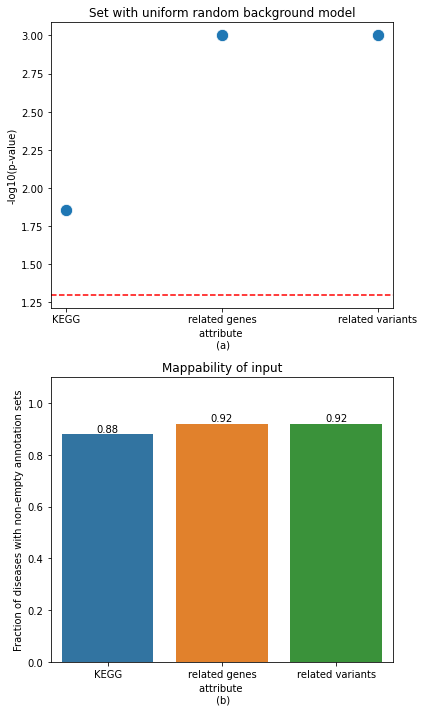

In [163]:
fig, axes = plt.subplots(2, 1, figsize=(6,10))
sns.scatterplot(x=data_df['attribute'], y=data_df['log_p-values'], s=150, ax=axes[0])
axes[0].set(title="Set with uniform random background model", ylabel="-log10(p-value)", xlabel="attribute \n (a)")
axes[0].axhline(y=-math.log10(0.05), color="red",linestyle='--')
sns.barplot(x ="attribute", y = 'fraction', data = mapped_df, ax=axes[1])
axes[1].set(title="Mappability of input", xlabel="attribute \n (b)", ylabel="Fraction of diseases with non-empty annotation sets", ylim=(0, 1.1))
for container in axes[1].containers:
    axes[1].bar_label(container,  fmt='%.2f')
fig.tight_layout() 
fig.savefig("mode_disease-set_uniform_overview.png", bbox_inches='tight')

In [164]:
tar_set = "input/target_disease_set.txt"
tar_id_type = "ICD-10"
mode = "set"
out_dir = "results/"
runs = 1000
background_model="term-pres"

In [165]:
single_validation(tar=tar_set, tar_id=tar_id_type, mode=mode, out_dir=out_dir, runs=runs, background_model=background_model)
with open(out_dir+'digest_'+mode+'_result.json', 'r') as f:
    data = json.load(f)

[00:00:00|2880.48MB] Starting validation ...
[00:00:03|2962.02MB] Load distances for input into cache ...
[00:04:33|3331.29MB] Finished validation


### Inspect results

In [166]:
# prepare scatter
data_df = data.copy()
data_df = pd.DataFrame.from_dict({'p_values':data_df["p_values"]})
data_df = data_df.rename_axis('attribute').reset_index()
data_df["log_p-values"] = data_df["p_values"].apply(lambda x: -math.log10(x))
data_df = data_df.replace({"disgenet.genes_related_to_disease":"related genes", "disgenet.variants_related_to_disease":"related variants", "ctd.pathway_related_to_disease":"KEGG"})
data_df = data_df.sort_values(['attribute']).reset_index(drop=True)
# prepare for mappibility plot
in_put = pd.read_csv(tar_set, sep="\t", names=["id", "desc"])
mapped_df = in_put.copy()
for att in data["input_values"]["mapped_ids"]:
    mapped_df[att] = [1 if x in data["input_values"]["mapped_ids"][att] else 0 for x in in_put["id"]]
mapped_df= mapped_df[["disgenet.genes_related_to_disease", "disgenet.variants_related_to_disease", "ctd.pathway_related_to_disease"]].T
mapped_df["count"] = mapped_df.sum(axis=1)
mapped_df["fraction"] = mapped_df['count'].apply(lambda x: x/len(in_put["id"]))
mapped_df = mapped_df.rename_axis('attribute').reset_index()
mapped_df = mapped_df.replace({"disgenet.genes_related_to_disease":"related genes", "disgenet.variants_related_to_disease":"related variants", "ctd.pathway_related_to_disease":"KEGG"})
mapped_df = mapped_df.sort_values(['attribute']).reset_index(drop=True)

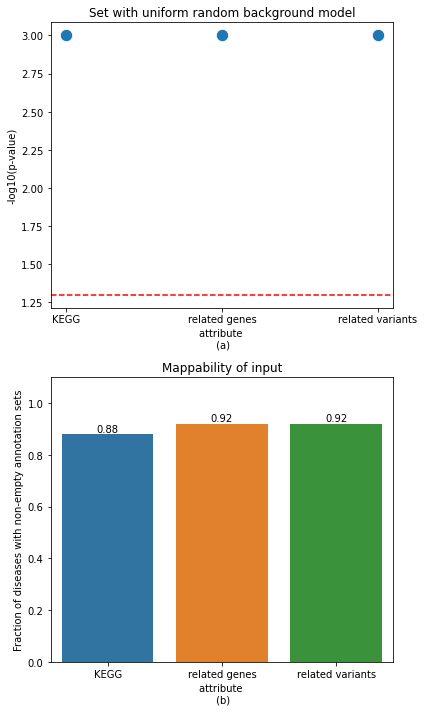

In [167]:
fig, axes = plt.subplots(2, 1, figsize=(6,10))
sns.scatterplot(x=data_df['attribute'], y=data_df['log_p-values'], s=150, ax=axes[0])
axes[0].set(title="Set with uniform random background model", ylabel="-log10(p-value)", xlabel="attribute \n (a)")
axes[0].axhline(y=-math.log10(0.05), color="red",linestyle='--')
sns.barplot(x ="attribute", y = 'fraction', data = mapped_df, ax=axes[1])
axes[1].set(title="Mappability of input", xlabel="attribute \n (b)", ylabel="Fraction of diseases with non-empty annotation sets", ylim=(0, 1.1))
for container in axes[1].containers:
    axes[1].bar_label(container,  fmt='%.2f')
fig.tight_layout() 
fig.savefig("mode_disease-set_uniform_overview.png", bbox_inches='tight')

In [168]:
data

{'input_values': {'value': {'disgenet.genes_related_to_disease': 7.732428110576978,
   'disgenet.variants_related_to_disease': 4.412785311058239,
   'ctd.pathway_related_to_disease': 1.0035455804963545},
  'mapped_ids': {'disgenet.genes_related_to_disease': ['E10',
    'E11',
    'E12',
    'E13',
    'E14',
    'E66',
    'F00',
    'F01',
    'G20',
    'G30',
    'G43',
    'I10',
    'I11',
    'I12',
    'I13',
    'I15',
    'I21',
    'I22',
    'I50',
    'I63',
    'I64',
    'I70',
    'J45'],
   'disgenet.variants_related_to_disease': ['E10',
    'E11',
    'E12',
    'E13',
    'E14',
    'E66',
    'F00',
    'F01',
    'G20',
    'G30',
    'G43',
    'I10',
    'I11',
    'I12',
    'I13',
    'I15',
    'I21',
    'I22',
    'I50',
    'I63',
    'I64',
    'I70',
    'J45'],
   'ctd.pathway_related_to_disease': ['E10',
    'E11',
    'E12',
    'E13',
    'E14',
    'E66',
    'F01',
    'G20',
    'G30',
    'G43',
    'I10',
    'I11',
    'I12',
    'I13',
    'I15'

While the values under `input_values` are the raw values for the input set, the values under `p_value` are the calculated p-values for the original input against the 1000 runs.

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), subplot_kw={'ylim': (0,1)})
fig.suptitle("Empirical P-Values for Gene Cluster", fontsize=16)
plot_df[plot_df["attribute"]=="go.BP"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[0,0], title="go.BP")
plot_df[plot_df["attribute"]=="go.CC"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[0,1], title="go.CC")
plot_df[plot_df["attribute"]=="go.MF"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[1,0], title="go.MF")
plot_df[plot_df["attribute"]=="pathway.kegg"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[1,1], title="pathway.kegg")

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), subplot_kw={'ylim': (0,1)})
fig.suptitle("Empirical P-Values for Gene Cluster", fontsize=16)
plot_df.pivot(index='perc', columns='attribute', values='di').plot(ax=axes[0,0], title="Dunn Index")
plot_df.pivot(index='perc', columns='attribute', values='ss').plot(ax=axes[0,1], title="Silhouette Score")
plot_df.pivot(index='perc', columns='attribute', values='dbi').plot(ax=axes[1,0], title="Davies Bouldin Index")
#plot_df[plot_df["attribute"]=="pathway.kegg"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[1,1], title="pathway.kegg")


In [ ]:
pd.DataFrame(results["10"]["input_values"])[["di","ss", "dbi"]]

In [ ]:
pd.DataFrame(results["10"]["input_values"]["ss_inter"])

In [ ]:
atts = pd.read_csv("../mapping_files/gene_att_mapping.csv")
cluster = pd.read_csv(tar_set, sep="\t", header=None)
atts = atts[atts['entrezgene'].isin(cluster[0])].fillna("")
atts.head()

In [ ]:
def string_to_len(x):
    return len(set(filter(None, x.split(";"))))
atts[atts.columns[1:]] = atts[atts.columns[1:]].applymap(string_to_len)

In [ ]:
atts

In [ ]:
cluster.rename(columns={0:"id",1:"cluster"})

In [ ]:
tar_set = "input/icd10_I-M_small.txt"
tar_id_type = "mondo"
mode = "cluster"
out_dir = "results/"
runs = 1000
perc = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [ ]:
results2 = dict()
for cur_perc in perc:
    single_validation(tar=tar_set, tar_id=tar_id_type, mode=mode, out_dir=out_dir, runs=runs, replace=cur_perc)
    with open(out_dir+'digest_'+mode+'_result.json', 'r') as f:
        results2[str(cur_perc)] = json.load(f)

In [ ]:
plot_df = pd.DataFrame(columns=["attribute","di","ss","dbi","perc"])
for cur_perc in perc:
    df = pd.DataFrame.from_dict(results2[str(cur_perc)]["p_values"])
    df["perc"] = str(cur_perc)
    df = df.rename_axis('attribute').reset_index()
    plot_df = pd.concat([plot_df, df])

In [ ]:
plot_df.head()

In [ ]:
plot_df["attribute"]

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), subplot_kw={'ylim': (0,1)})
fig.suptitle("Empirical P-Values for Disease Cluster", fontsize=16)
plot_df[plot_df["attribute"]=="disgenet.genes_related_to_disease"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[0,0], title="disgenet.genes_related_to_disease")
plot_df[plot_df["attribute"]=="disgenet.variants_related_to_disease"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[0,1], title="disgenet.variants_related_to_disease")
plot_df[plot_df["attribute"]=="ctd.pathway_related_to_disease"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[1,0], title="ctd.pathway_related_to_disease")

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), subplot_kw={'ylim': (0,1)})
fig.suptitle("Empirical P-Values for Disease Cluster", fontsize=16)
plot_df.pivot(index='perc', columns='attribute', values='di').plot(ax=axes[0,0], title="Dunn Index")
plot_df.pivot(index='perc', columns='attribute', values='ss').plot(ax=axes[0,1], title="Silhouette Score")
plot_df.pivot(index='perc', columns='attribute', values='dbi').plot(ax=axes[1,0], title="Davies Bouldin Index")
#plot_df[plot_df["attribute"]=="pathway.kegg"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[1,1], title="pathway.kegg")


In [ ]:
tar_set = "input/mondo_cluster.txt"
tar_id_type = "mondo"
mode = "cluster"
out_dir = "results/"
runs = 1000
perc = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [ ]:
results3 = dict()
for cur_perc in perc:
    single_validation(tar=tar_set, tar_id=tar_id_type, mode=mode, out_dir=out_dir, runs=runs, replace=cur_perc)
    with open(out_dir+'digest_'+mode+'_result.json', 'r') as f:
        results3[str(cur_perc)] = json.load(f)

In [ ]:
plot_df = pd.DataFrame(columns=["attribute","di","ss","dbi","perc"])
for cur_perc in perc:
    df = pd.DataFrame.from_dict(results3[str(cur_perc)]["p_values"])
    df["perc"] = str(cur_perc)
    df = df.rename_axis('attribute').reset_index()
    plot_df = pd.concat([plot_df, df])

In [ ]:
plot_df.head()

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), subplot_kw={'ylim': (0,1)})
fig.suptitle("Empirical P-Values for Disease Cluster", fontsize=16)
plot_df[plot_df["attribute"]=="disgenet.genes_related_to_disease"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[0,0], title="disgenet.genes_related_to_disease")
plot_df[plot_df["attribute"]=="disgenet.variants_related_to_disease"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[0,1], title="disgenet.variants_related_to_disease")
plot_df[plot_df["attribute"]=="ctd.pathway_related_to_disease"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[1,0], title="ctd.pathway_related_to_disease")

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), subplot_kw={'ylim': (0,1)})
fig.suptitle("Empirical P-Values for Disease Cluster", fontsize=16)
plot_df.pivot(index='perc', columns='attribute', values='di').plot(ax=axes[0,0], title="Dunn Index")
plot_df.pivot(index='perc', columns='attribute', values='ss').plot(ax=axes[0,1], title="Silhouette Score")
plot_df.pivot(index='perc', columns='attribute', values='dbi').plot(ax=axes[1,0], title="Davies Bouldin Index")
#plot_df[plot_df["attribute"]=="pathway.kegg"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[1,1], title="pathway.kegg")


In [ ]:
tar_set = "input/target_disease_set.txt"
tar_id_type = "ICD-10"
mode = "set"
out_dir = "results/"
runs = 1000
perc = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [ ]:
results4 = dict()
for cur_perc in perc:
    single_validation(tar=tar_set, tar_id=tar_id_type, mode=mode, out_dir=out_dir, runs=runs, replace=cur_perc)
    with open(out_dir+'digest_'+mode+'_result.json', 'r') as f:
        results4[str(cur_perc)] = json.load(f)

In [ ]:
plot_df = pd.DataFrame(columns=["attribute","p_values","perc"])
for cur_perc in perc:
    df = pd.DataFrame.from_dict(results4[str(cur_perc)])
    df["perc"] = str(cur_perc)
    df = df.rename_axis('attribute').reset_index()
    plot_df = pd.concat([plot_df, df])
    plot_df = plot_df[["attribute","p_values","perc"]]

In [ ]:
plot_df

In [ ]:
pd.DataFrame(results4["10"])

In [ ]:
plot_df

In [ ]:
pd.DataFrame(results2["10"]["input_values"])[["di","ss", "dbi"]]

In [ ]:
pd.DataFrame(results2["10"]["input_values"]["ss_inter"])

In [ ]:
pd.DataFrame(results3["10"]["input_values"])[["di","ss", "dbi"]]

In [ ]:
pd.DataFrame(results3["10"]["input_values"]["ss_inter"])

In [ ]:
plot_df.pivot(index='perc', columns='attribute', values='p_values').plot(title="Dunn Index", ylim= (0,1))

In [ ]:
pd.DataFrame(results4["10"]["input_values"].items())

In [ ]:
import scipy.sparse as sp
df = sp.load_npz("../mapping_files/disease_dist_rel_genes.npz").tocsr()

In [ ]:
df = None

In [ ]:
with open("https://api.nedrex.net/disorder_is_subtype_of_disorder/all", 'r') as f:
        f

In [ ]:
pd.read_csv("https://api.nedrex.net/disorder_is_subtype_of_disorder/all")

In [ ]:
d = pd.DataFrame(columns=["id","cluster","desc"])
d["id"] = ["H"+str(x).zfill(2) for x in list(range(0,60))]
d["cluster"] = "0"
d["desc"] = "Krankheiten des Auges und der Augenanhangsgebilde"
d_fin = pd.concat([d_fin, d])

In [ ]:
d = pd.DataFrame(columns=["id","cluster","desc"])
d["id"] = ["M"+str(x).zfill(2) for x in list(range(0,100))]
d["cluster"] = "1"
d["desc"] = "Krankheiten des Muskel-Skelett-Systems und des Bindegewebes"
d_fin = pd.concat([d_fin, d])

In [ ]:
d = pd.DataFrame(columns=["id","cluster","desc"])
d["id"] = ["G"+str(x).zfill(2) for x in list(range(0,100))]
d["cluster"] = "2"
d["desc"] = "Krankheiten des Nervensystems"
d_fin = pd.concat([d_fin, d])

In [ ]:
d = pd.DataFrame(columns=["id","cluster","desc"])
d["id"] = ["E"+str(x).zfill(2) for x in list(range(0,91))]
d["cluster"] = "3"
d["desc"] = "Endokrine, Ernährungs- und Stoffwechselkrankheiten"
d_fin = pd.concat([d_fin, d])

In [ ]:
d = pd.DataFrame(columns=["id","cluster","desc"])
d["id"] = ["J"+str(x).zfill(2) for x in list(range(0,100))]
d["cluster"] = "4"
d["desc"] = "Krankheiten des Atmungssystems"
d_fin = pd.concat([d_fin, d])

In [ ]:
d_fin.to_csv("icd10_cluster.txt", sep="\t", index=False, header=False)